# Finding the Optimal Movies Duration for Gross Sales

This project is about finding the optimal watch time across all the movies that generate the highest gross sales. 


In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as mticker
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
# import dataset
df=pd.read_csv('C:\\Users\\sanny\\OneDrive\\Documents\\Datasets\\movie_data_python\\Top Ranked Real Movies Dataset.csv')

# show the top rows dataset
df.head()

,Unnamed: 0,Movie Name,Year of Release,Watch Time,Movie Rating,Meatscore of movie,Votes,Gross,Description
0,0,Jai Bhim,-2021,164 min,9.4,NaN,"180,702",NaN,When a tribal man is arrested for a case of al...
1,1,Soorarai Pottru,-2020,153 min,9.3,NaN,"108,490",NaN,"Nedumaaran Rajangam ""Maara"" sets out to make t..."
2,2,The Shawshank Redemption,-1994,142 min,9.3,81.0,"2,559,534",$28.34M,Two imprisoned men bond over a number of years...
3,3,The Godfather,-1972,175 min,9.2,100.0,"1,761,949",$134.97M,The aging patriarch of an organized crime dyna...
4,4,The Dark Knight,-2008,152 min,9.1,84.0,"2,519,388",$534.86M,When the menace known as the Joker wreaks havo...


After looking at the data, we can see that the values of the columns are not the format that would be desirable to conduct analysis on. That is why we need to do some data cleaning instead of diving into the data right on and face problems later on.


In [3]:
# cleaning the data

# remove the '-' from the Year of Release value
df['Year of Release'] = df['Year of Release'].str.replace('-', '')

# changing the format of the ['Year of Release'] format
df['Year of Release'] = pd.to_datetime(df['Year of Release'], errors='coerce', format='%Y')
df['Year of Release'] = df['Year of Release'].dt.year.astype('Int64')

# removing the '-' from the value on the watch time column
df['Watch Time'] = df['Watch Time'].str.replace('min', '').astype(float)

In [4]:
# fixing the format of the ['Gross'] column
# remove the unit messure from the value and return it as decimal numbers
def convert_gross(value):
    try:
        if isinstance(value, str):
            if 'M' in value:
                return float(value.replace('$', '').replace('M', '')) * 1e6
            elif 'K' in value:
                return float(value.replace('$', '').replace('K', '')) * 1e3
            else:
                return float(value.replace('$', ''))
        else:
            return float(value)
    except ValueError:
        return None  

df['Gross'] = df['Gross'].apply(convert_gross).astype(float)

# Convert 'Gross' to millions for better readability
df['Gross (Millions)'] = df['Gross'] / 1e6

# looking at the summary of the data
df.describe()


,Unnamed: 0,Year of Release,Watch Time,Movie Rating,Meatscore of movie,Gross,Gross (Millions)
count,1002.000000,969.0,1002.000000,1002.000000,838.000000,8.210000e+02,821.000000
mean,500.500000,1990.626419,123.597804,7.976747,78.533413,7.013088e+07,70.130877
std,289.396786,23.806702,28.453985,0.291759,12.082283,1.111655e+08,111.165538
min,0.000000,1920.0,45.000000,7.600000,28.000000,0.000000e+00,0.000000
25%,250.250000,1975.0,103.000000,7.700000,71.000000,3.360000e+06,3.360000
50%,500.500000,1998.0,120.000000,7.900000,79.000000,2.461000e+07,24.610000
75%,750.750000,2009.0,137.750000,8.100000,88.000000,8.630000e+07,86.300000
max,1001.000000,2023.0,321.000000,9.400000,100.000000,9.366600e+08,936.660000


The dataset consists of information on 1002 movies spanning from 1920 to 2023. Movie durations average around 123.6 minutes, and ratings tend to be on the higher scale, averaging close to 8. The dataset also includes Meatscore of movies for 838 movies, ranging from 28 to 100. Gross sales vary widely, with an average of $70.13 million and a maximum of $936.66 million, and the standard deviation is notable at 111.17.

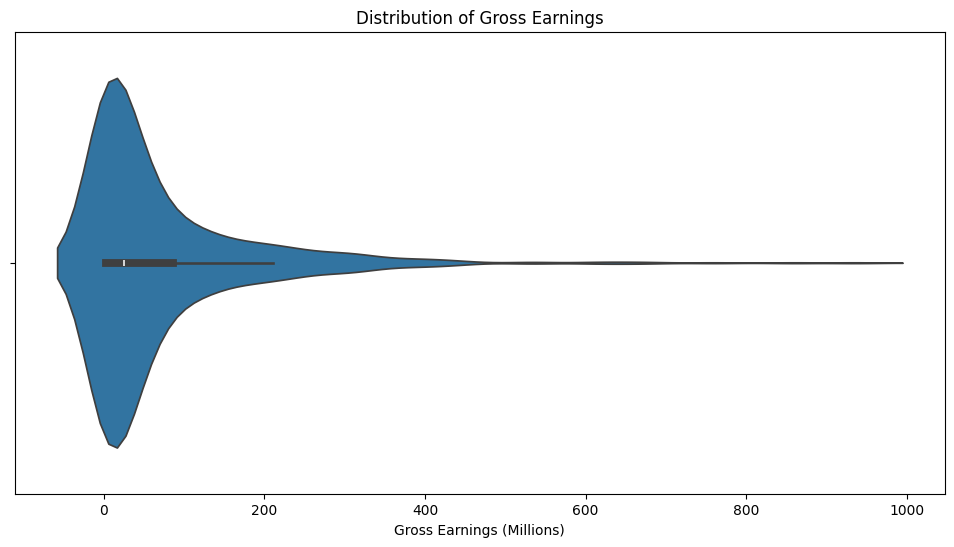

In [5]:
# visualize the data 
plt.figure(figsize=(12, 6))
sns.violinplot(x=df['Gross'] / 1e6)  # Convert 'Gross' to millions for better readability
plt.title('Distribution of Gross Earnings')
plt.xlabel('Gross Earnings (Millions)')
plt.show()

This graph is help to visualize the distribution of gross earning across the movies. It appears that most movies fall under the 200 million earning club and the highest earning movie to be way above out of all the movies.

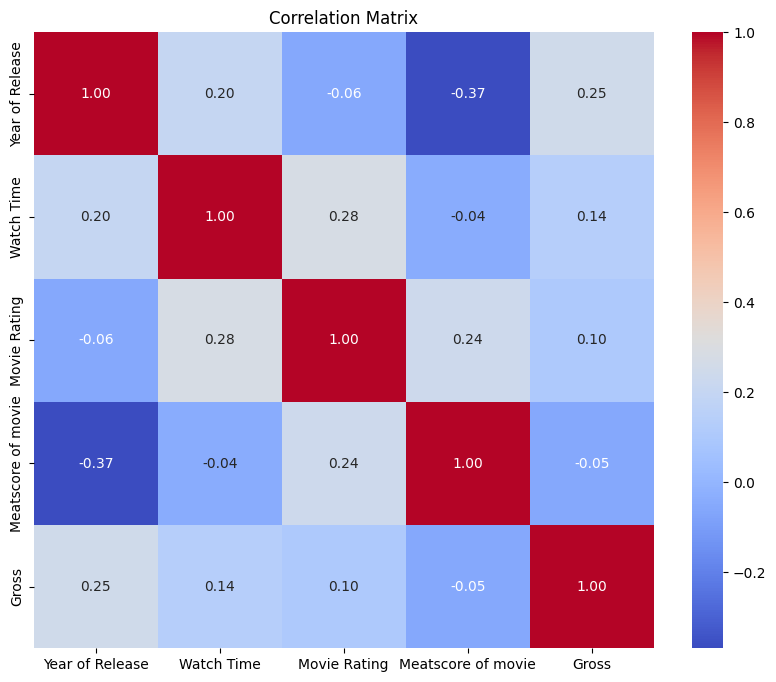

In [6]:
# matrix correlation of the values
# group the values
selected_columns = ['Year of Release', 'Watch Time', 'Movie Rating', 'Meatscore of movie', 'Gross']

df_selected = df[selected_columns]

# calculate the correlation matrix
correlation_matrix = df_selected.corr()

# plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

There are serveal correlation values shown on the heatmap but we are here to find the correlation for Watch Time and Gross. The correlation value for is 0.14, the value tell us that there is very weak correlation between the two value. With the correlation value we can tell that the longer the movie it does not mean that the gross would also go along with it, because of this to find the optimal grossing movie watch time we need to do some calculations.

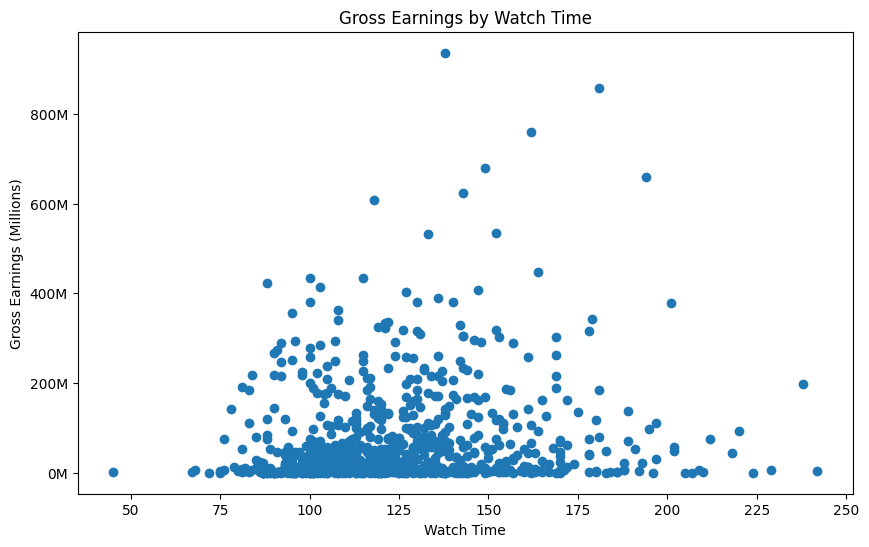

Optimal Watch Time for Highest Gross: 138.0 minutes


In [7]:
# making scatter plot
# grouping 'Watch Time' and 'Gross' columns
df_watch_gross = df[['Watch Time', 'Gross']]

# sort the DataFrame by 'Gross' in descending order
df_sorted_by_gross = df_watch_gross.sort_values(by='Gross', ascending=False)

# scatter plot to show the relationship
plt.figure(figsize=(10, 6))
plt.scatter(df_sorted_by_gross['Watch Time'], df_sorted_by_gross['Gross'])
plt.title('Gross Earnings by Watch Time')
plt.xlabel('Watch Time')
plt.ylabel('Gross Earnings (Millions)')

# custom formatter for y-axis ticks
def format_millions(x, pos):
    return f'{x / 1e6:.0f}M'

formatter = mticker.FuncFormatter(format_millions)
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

To give us a better look of the gross earning by watch time distribution, scatter plot can help us visualize the data to help us to understand the data more and to spot outliers.

In [11]:
optimal_watch_time_all_movies = df_sorted_by_gross.groupby('Watch Time')['Gross'].sum().idxmax()
print(f'Most Optimal Watch Time for Highest Total Gross: {optimal_watch_time_all_movies} minutes')

Most Optimal Watch Time for Highest Total Gross: 100.0 minutes


The following lines of code are designed to determine the optimal watch time that yields the highest gross sales across all movies in the dataset, keep in mind that this result is prior to doing any outlier removal. These 2 line of codes look at the dataset, grouping them based on their 'Watch Time', then adds up how much money each group of 'Watch Time' generates, and find the 'Watch Time' that makes the money overall. The optimal Watch Time appears to be 100 minutes.

In [8]:
# getting the outliers out
# getting rid of outliers using  IQR method
Q1 = df[['Watch Time', 'Movie Rating', 'Meatscore of movie', 'Gross']].quantile(0.25)
Q3 = df[['Watch Time', 'Movie Rating', 'Meatscore of movie', 'Gross']].quantile(0.75)
IQR = Q3 - Q1

# Remove outliers based on IQR
df_no_outliers = df[~((df[['Watch Time', 'Movie Rating', 'Meatscore of movie', 'Gross']] < (Q1 - 1.5 * IQR)) | (df[['Watch Time', 'Movie Rating', 'Meatscore of movie', 'Gross']] > (Q3 + 1.5 * IQR))).any(axis=1)]

To get rid of the outliers I decided to use the IQR Method, this method is known for its robustness for taking outliers because of its effectiveness with handling extreme values.

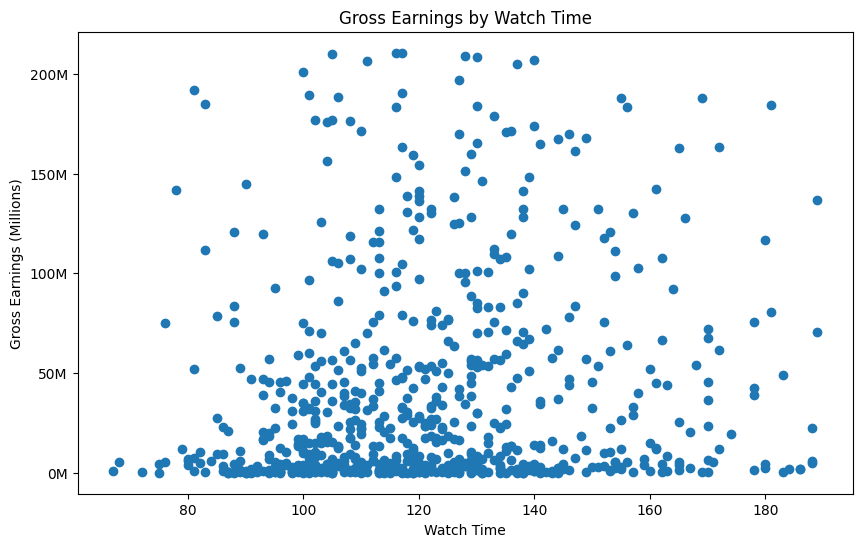

In [14]:
# calculate the optimal watch time with no outliers for movies to get the most gross sales
df_watch_gross_no_outliers = df_no_outliers[['Watch Time', 'Gross']]

# sort the dataframe that has been outlined by 'Gross' in decending order
df_sorted_by_gross_no_outliers = df_watch_gross_no_outliers.sort_values(by='Gross', ascending=False)

# scatter plot to show the relationship
plt.figure(figsize=(10, 6))
plt.scatter(df_sorted_by_gross_no_outliers['Watch Time'], df_sorted_by_gross_no_outliers['Gross'])
plt.title('Gross Earnings by Watch Time')
plt.xlabel('Watch Time')
plt.ylabel('Gross Earnings (Millions)')

# custom formatter for y-axis ticks
def format_millions(x, pos):
    return f'{x / 1e6:.0f}M'

formatter = mticker.FuncFormatter(format_millions)
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()


This scatter plot contains the filtered values from the outliers, based on the IQR method.

In [12]:
optimal_watch_time_all_movies = df_sorted_by_gross_no_outliers.groupby('Watch Time')['Gross'].sum().idxmax()
print(f'Most Optimal Watch Time for Highest Total Gross: {optimal_watch_time_all_movies} minutes')

Most Optimal Watch Time for Highest Total Gross: 130.0 minutes


After removing outliers from the dataset, it seems that the most suitable movie duration is identified as 130 minutes. This value comes more closely with the average duration of successful movies, providing a more sensible estimate for optimal watch time. This adjustment is meaningful as it better represents the typical watch time associated with movies that have performed well in terms of gross revenue